$$\textbf{Artificial intelligence algorithms}$$
$$\textbf{Mini project on :}$$
$$\texttt{Digit Recognition using Artifical Neural Nets.}$$


$\textbf{Project Overview}$
This project implements a deep learning solution for the Kaggle Digit Recognizer competition, which uses the famous MNIST dataset. The goal is to correctly identify digits from handwritten images.
Dataset

- $\texttt{Source:}$ Modified National Institute of Standards and Technology (MNIST) database 
- $\texttt{Features:}$ 28x28 pixel grayscale images of handwritten digits (0-9) 
- $\texttt{Training set:}$ 42,000 labeled images 
- $\texttt{Test set:}$ 28,000 unlabeled images for submission 


$\textbf{Python Libraries}$

- `pandas`, `numpy`  
  → For data handling, dataframes, arrays, and numeric computations.
- `matplotlib.pyplot`, `seaborn`  
  → For visualizations, plots, and heatmaps.  
    $ \text{Used for EDA (Exploratory Data Analysis)} $

- `warnings`  
  → Suppresses unnecessary warnings to keep the output clean.


$\textbf{Scikit-learn (sklearn)}$

- `train_test_split`  
  → Splits data into training and testing sets.
- `StratifiedKFold`  
  → For cross-validation while preserving class distribution.
- `accuracy_score`, `confusion_matrix`  
  → To evaluate model performance using metrics and diagnostic tools.

$\textbf{TensorFlow / Keras}
- `tensorflow.keras.models`, `layers`  
  → Build neural network layers: Dense, Conv2D, MaxPooling, Flatten, etc.
- `ImageDataGenerator`  
  → For real-time data augmentation during training.
- `ReduceLROnPlateau`, `EarlyStopping`, `ModelCheckpoint`  
  → Callbacks for better model training:  
    $ 
    \text{Reduce learning rate} \quad \text{+} \quad \text{Stop early} \quad \text{+} \quad \text{Save best model} 
    $
- `Adam`  
  → Optimizer that adapts the learning rate for each parameter.
- `to_categorical`  
  → Converts class labels (e.g., 5) to one-hot encoded vectors:
    $
    5 \rightarrow [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    $

$\textbf{SciPy (Optional)}$
- `rotate`, `shift` from `scipy.ndimage`  
  → For test-time augmentation (TTA), such as rotating or shifting images to simulate real-world variations.
TTA is only used if SciPy is available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False

try:
    from scipy.ndimage import rotate, shift as scipy_shift
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False



The system follows several key object-oriented design patterns:
$\textbf{Class Hierarchy Structure}$

BaseDataProcessor (Abstract)

├── DigitDataProcessor (Concrete)

BaseModel (Abstract)

├── CNNModel (Concrete)

├── ResNetModel (Concrete)

└── AlternativeCNNModel (Concrete)

BaseEnsemble (Abstract)

├── DigitRecognitionEnsemble (Concrete)

DigitRecognitionSystem (Composition)

├── Uses: DigitDataProcessor

├── Uses: DigitRecognitionEnsemble

└── Uses: DataAugmentor


$$\textbf{Base classes (parent classes)}$$

In [2]:
class BaseDataProcessor(ABC):
    """Abstract base class for data processing"""
    def __init__(self):
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.X_test = None
    
    @abstractmethod
    def load_data(self, train_path, test_path=None):
        """Abstract method - must be implemented by child classes"""
        pass
    
    @abstractmethod
    def preprocess_data(self, X, y=None):
        """Abstract method for preprocessing"""
        pass
    
    def split_data(self, X, y, test_size=0.1, random_state=42):
        """Common method for splitting data"""
        return train_test_split(X, y, test_size=test_size, 
                               random_state=random_state, stratify=y)


class BaseModel(ABC):
    """Abstract base class for all models"""
    
    def __init__(self, name):
        self.name = name
        self.model = None
        self.history = None
        self.is_trained = False
    
    @abstractmethod
    def build_model(self, input_shape):
        """Abstract method to build the model architecture"""
        pass
    
    @abstractmethod
    def compile_model(self):
        """Abstract method to compile the model"""
        pass
    
    def train(self, X_train, y_train, X_val, y_val, **kwargs):
        """Common training method"""
        if not self.model:
            raise ValueError("Model not built. Call build_model() first.")
        
        if not self.is_compiled():
            self.compile_model()
        
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs
        )
        self.is_trained = True
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        if not self.is_trained:
            raise ValueError("Model not trained yet.")
        return self.model.predict(X)
    
    def is_compiled(self):
        """Check if model is compiled"""
        return hasattr(self.model, 'optimizer')
    
    def save_model(self, filepath):
        """Save the trained model"""
        if self.model:
            self.model.save(f"{filepath}_{self.name}.h5")


class BaseEnsemble(ABC):
    """Abstract base class for ensemble methods"""
    
    def __init__(self):
        self.models = []
        self.model_histories = []
    
    @abstractmethod
    def create_models(self, input_shape):
        """Create all models for the ensemble"""
        pass
    
    @abstractmethod
    def ensemble_predict(self, X):
        """Make ensemble predictions"""
        pass
    
    def add_model(self, model):
        """Add a model to the ensemble"""
        if isinstance(model, BaseModel):
            self.models.append(model)
        else:
            raise TypeError("Model must inherit from BaseModel")
    
    def train_all_models(self, X_train, y_train, X_val, y_val, **kwargs):
        """Train all models in the ensemble"""
        for model in self.models:
            print(f"Training {model.name}...")
            history = model.train(X_train, y_train, X_val, y_val, **kwargs)
            self.model_histories.append(history)

$$\textbf{ Data processing (Child classes)}$$


**Key Features**:
- **Normalization**: Converts pixel values from 0-255 to 0-1 range
- **Reshaping**: Transforms flat arrays into proper image tensors (28×28×1)
- **One-hot encoding**: Converts class labels to categorical format
- **Train/validation split**: Automatically splits data with stratification

```python
# Data flow example:
Raw CSV → Load → Reshape → Normalize → One-hot encode → Train/Val split
```

**What makes it different**: Unlike simple data loading, this processor encapsulates all preprocessing logic in a reusable, extensible class that can be easily modified for different image datasets.

In [3]:
class DigitDataProcessor(BaseDataProcessor):
    """Specialized data processor for digit recognition"""
    
    def __init__(self, image_size=(28, 28), num_classes=10):
        super().__init__()
        self.image_size = image_size
        self.num_classes = num_classes
    
    def load_data(self, train_path, test_path=None):
        """Load digit recognition data from CSV"""
        print("Loading data...")
        train_df = pd.read_csv(train_path)
        
        # Split features and labels
        X = train_df.drop('label', axis=1).values
        y = train_df['label'].values
        
        # Preprocess the data
        X_processed, y_processed = self.preprocess_data(X, y)
        
        # Split into train and validation
        self.X_train, self.X_val, self.y_train, self.y_val = self.split_data(
            X_processed, y_processed
        )
        
        # Load test data if provided
        if test_path:
            test_df = pd.read_csv(test_path)
            self.X_test, _ = self.preprocess_data(test_df.values)
        
        self._print_data_info()
        return self.X_train, self.X_val, self.y_train, self.y_val, self.X_test
    
    def preprocess_data(self, X, y=None):
        """Preprocess digit images"""
        # Reshape to image format
        X_processed = X.reshape(-1, *self.image_size, 1)
        
        # Normalize pixel values
        X_processed = X_processed.astype('float32') / 255.0
        
        # One-hot encode labels if provided
        if y is not None:
            y_processed = to_categorical(y, self.num_classes)
            return X_processed, y_processed
        
        return X_processed, None
    
    def _print_data_info(self):
        """Print information about loaded data"""
        print(f"Training data shape: {self.X_train.shape}")
        print(f"Validation data shape: {self.X_val.shape}")
        if self.X_test is not None:
            print(f"Test data shape: {self.X_test.shape}")


class DataAugmentor:
    """Helper class for data augmentation"""
    
    def __init__(self, **augmentation_params):
        self.augmentation_params = augmentation_params
        self.generator = None
    
    def create_generator(self):
        """Create ImageDataGenerator with specified parameters"""
        default_params = {
            'rotation_range': 10,
            'zoom_range': 0.1,
            'width_shift_range': 0.1,
            'height_shift_range': 0.1,
            'shear_range': 0.1,
            'fill_mode': 'nearest'
        }
        default_params.update(self.augmentation_params)
        
        self.generator = ImageDataGenerator(**default_params)
        return self.generator
    
    def fit_generator(self, X_train):
        """Fit the generator to training data"""
        if not self.generator:
            self.create_generator()
        self.generator.fit(X_train)

$$\textbf{Model classes (Child classes)}$$

$\textbf{Model Architectures}$

$\textbf{1. Standard CNN Model (CNNModel)}$

**Architecture Philosophy**: Traditional convolutional approach with progressive feature extraction.

**Key Components**:
- **3 Convolutional blocks** with increasing filter sizes (32 → 64 → 128)
- **Batch normalization** after each conv layer for stable training
- **MaxPooling** for spatial dimension reduction
- **Dropout layers** (0.25, 0.5) for regularization
- **Dense layers** with 512 units for final classification

**Distinctive Features**:
- Follows classic CNN pattern: Conv → BatchNorm → Conv → Pool → Dropout
- Uses ReLU activation throughout
- Progressive filter increase captures hierarchical features

$\textbf{2. ResNet-Inspired Model (ResNetModel)}$

**Architecture Philosophy**: Implements residual connections to enable deeper networks and solve vanishing gradient problem.

**Key Innovation - Skip Connections**:
```python
# Residual block structure:
input → conv → batchnorm → relu → conv → batchnorm → (+) → relu
  ↓                                                    ↑
  └─────────────── shortcut connection ──────────────┘
```

**Distinctive Features**:
- **Residual blocks** with skip connections
- **Identity mapping** when dimensions match
- **1×1 convolutions** for dimension adjustment in shortcuts
- **Global Average Pooling** instead of flatten (reduces parameters)

**What makes it different**: The skip connections allow gradients to flow directly through the network, enabling training of deeper models and often achieving better accuracy than standard CNNs.

$\textbf{3. Alternative CNN Model (AlternativeCNNModel)}$

**Architecture Philosophy**: Explores different design choices for comparison.

**Distinctive Design Choices**:
- **Larger initial kernel** (5×5) vs standard 3×3
- **Higher initial filters** (64) for more feature detection
- **Global Average Pooling** reduces overfitting
- **Larger dense layer** (1024 units) for more representation power

**What makes it different**: This model tests the hypothesis that different kernel sizes and architectural choices might capture different aspects of digit patterns.


In [4]:
class CNNModel(BaseModel):
    """Standard CNN model for digit recognition"""
    
    def __init__(self, name="CNN"):
        super().__init__(name)
        self.filters = [32, 64, 128]
        self.dense_units = 512
    
    def build_model(self, input_shape):
        """Build a standard CNN architecture"""
        self.model = keras.Sequential()
        
        # First convolutional block
        self.model.add(layers.Conv2D(self.filters[0], (3, 3), 
                                   activation='relu', input_shape=input_shape))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Conv2D(self.filters[0], (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Dropout(0.25))
        
        # Second convolutional block
        self.model.add(layers.Conv2D(self.filters[1], (3, 3), activation='relu'))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Conv2D(self.filters[1], (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Dropout(0.25))
        
        # Third convolutional block
        self.model.add(layers.Conv2D(self.filters[2], (3, 3), activation='relu'))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Dropout(0.25))
        
        # Dense layers
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(self.dense_units, activation='relu'))
        self.model.add(layers.BatchNormalization())
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(10, activation='softmax'))
        
        return self.model
    
    def compile_model(self):
        """Compile the CNN model"""
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


class ResNetModel(BaseModel):
    """ResNet-inspired model"""
    
    def __init__(self, name="ResNet"):
        super().__init__(name)
        self.filters = [32, 64, 128]
    
    def build_model(self, input_shape):
        """Build a ResNet-inspired architecture"""
        inputs = layers.Input(shape=input_shape)
        
        # Initial conv layer
        x = layers.Conv2D(self.filters[0], (3, 3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # ResNet blocks
        x = self._create_resnet_block(x, self.filters[0])
        x = self._create_resnet_block(x, self.filters[0])
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)
        
        x = self._create_resnet_block(x, self.filters[1], strides=(2, 2))
        x = self._create_resnet_block(x, self.filters[1])
        x = layers.Dropout(0.25)(x)
        
        x = self._create_resnet_block(x, self.filters[2], strides=(2, 2))
        x = self._create_resnet_block(x, self.filters[2])
        x = layers.Dropout(0.25)(x)
        
        # Final layers
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(10, activation='softmax')(x)
        
        self.model = keras.Model(inputs, outputs)
        return self.model
    
    def _create_resnet_block(self, x, filters, kernel_size=(3, 3), strides=(1, 1)):
        """Create a ResNet-style block with skip connection"""
        shortcut = x
        
        # First conv layer
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Second conv layer
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        # Adjust shortcut if needed
        if strides != (1, 1) or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        # Add shortcut (this is the key ResNet innovation!)
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        
        return x
    
    def compile_model(self):
        """Compile the ResNet model"""
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


class AlternativeCNNModel(BaseModel):
    """Alternative CNN architecture"""
    
    def __init__(self, name="AltCNN"):
        super().__init__(name)
    
    def build_model(self, input_shape):
        """Build an alternative CNN architecture"""
        self.model = keras.Sequential([
            layers.Conv2D(64, (5, 5), activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            
            layers.GlobalAveragePooling2D(),
            layers.Dense(1024, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])
        
        return self.model
    
    def compile_model(self):
        """Compile the alternative CNN model"""
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )


$$\textbf{Ensemble classes (child classes)}$$


**Ensemble Philosophy**: Combines predictions from multiple diverse models to achieve better performance than any single model.

**Key Components**:

1. **Model Diversity**: Uses three different architectures
   - Standard CNN (traditional approach)
   - ResNet-inspired (skip connections)
   - Alternative CNN (different design choices)

2. **Prediction Aggregation**:
   - **Simple averaging**: `final_prediction = mean(model1_pred, model2_pred, model3_pred)`
   - **Class prediction**: `argmax(averaged_probabilities)`

3. **Test-Time Augmentation (TTA)**:
   - Applies small rotations (-5°, +5°) to test images
   - Averages predictions across augmented versions
   - Improves robustness to slight variations

**What makes ensembles powerful**:
- **Bias-Variance Trade-off**: Different models have different biases
- **Error Reduction**: Uncorrelated errors tend to cancel out
- **Robustness**: Less likely to fail catastrophically on edge cases


In [6]:
class DigitRecognitionEnsemble(BaseEnsemble):
    """Ensemble specifically for digit recognition"""
    def __init__(self):
        super().__init__()
        self.data_processor = None
        self.augmentor = None
    
    def create_models(self, input_shape):
        """Create all models for digit recognition ensemble"""
        # Create different model architectures
        cnn_model = CNNModel("CNN")
        cnn_model.build_model(input_shape)
        
        resnet_model = ResNetModel("ResNet")
        resnet_model.build_model(input_shape)
        
        alt_cnn_model = AlternativeCNNModel("AltCNN")
        alt_cnn_model.build_model(input_shape)
        
        # Add to ensemble
        self.add_model(cnn_model)
        self.add_model(resnet_model)
        self.add_model(alt_cnn_model)
        
        return self.models
    
    def ensemble_predict(self, X, use_tta=False):
        """Make ensemble predictions with optional TTA"""
        print("Making ensemble predictions...")
        
        if use_tta and SCIPY_AVAILABLE:
            return self._ensemble_predict_with_tta(X)
        else:
            return self._simple_ensemble_predict(X)
    
    def _simple_ensemble_predict(self, X):
        """Simple ensemble prediction without TTA"""
        predictions = []
        for model in self.models:
            pred = model.predict(X)
            predictions.append(pred)
        
        # Average all predictions
        ensemble_pred = np.mean(predictions, axis=0)
        return np.argmax(ensemble_pred, axis=1)
    
    def _ensemble_predict_with_tta(self, X):
        """Ensemble prediction with Test-Time Augmentation"""
        print("Using Test-Time Augmentation...")
        
        ensemble_predictions = []
        
        for model in self.models:
            model_predictions = []
            
            # Original prediction
            model_predictions.append(model.predict(X))
            
            # TTA predictions
            for angle in [-5, 5]:
                try:
                    rotated = self._rotate_images(X, angle)
                    model_predictions.append(model.predict(rotated))
                except Exception as e:
                    print(f"Skipping rotation {angle}°: {e}")
            
            # Average TTA predictions for this model
            avg_model_pred = np.mean(model_predictions, axis=0)
            ensemble_predictions.append(avg_model_pred)
        
        # Average ensemble predictions
        final_predictions = np.mean(ensemble_predictions, axis=0)
        return np.argmax(final_predictions, axis=1)
    
    def _rotate_images(self, images, angle):
        """Rotate images for TTA"""
        if not SCIPY_AVAILABLE:
            return images
        
        rotated = np.array([rotate(img.squeeze(), angle, reshape=False, mode='nearest') 
                           for img in images])
        return rotated.reshape(-1, 28, 28, 1).astype('float32')

$\textbf{Data Augmentation Strategy}$

**DataAugmentor Class**

**Purpose**: Artificially increases dataset size and model robustness.

**Augmentation Techniques**:
- **Rotation**: ±10 degrees (handles slight tilts)
- **Zoom**: ±10% (handles size variations)
- **Shifts**: ±10% width/height (handles positioning)
- **Shear**: ±10% (handles perspective distortions)

**Implementation Strategy**:
- Uses Keras `ImageDataGenerator` for real-time augmentation
- Generates augmented samples during training (not stored)
- Only applied to training data (not validation/test)

**What makes it effective**: Exposes the model to realistic variations it might encounter in real-world scenarios without manually collecting more data.

$\textbf{Training Strategy}$

$\textbf{Advanced Training Features}$

1. **Learning Rate Scheduling**:
   - `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus
   - Helps fine-tune the model in later epochs

2. **Early Stopping**:
   - Monitors validation loss to prevent overfitting
   - Restores best weights when training stops

3. **Batch Processing**:
   - Default batch size of 128 balances memory usage and gradient stability

$\textbf{Training Workflow}$

```
Load Data → Create Models → Setup Callbacks → Train with Augmentation → Evaluate
```

Each model in the ensemble is trained independently, allowing for:
- **Parallel training** potential
- **Individual model analysis**
- **Fault tolerance** (if one model fails, others continue)

$\textbf{Evaluation Approach}

**Multi-Level Evaluation**

1. **Individual Model Performance**: Each model evaluated separately
2. **Ensemble Performance**: Combined prediction accuracy
3. **Comparison Analysis**: Shows improvement from ensemble approach

**Metrics Used**

- **Accuracy**: Primary metric for classification performance
- **Training History**: Loss and accuracy curves for analysis
- **Validation Performance**: Prevents overfitting assessment

$$\textbf{Main system class (we used composition here btw)}$$


$\textbf{DigitRecognitionSystem Class}$

**Role**: Orchestrates all components into a cohesive system.

**Composition Strategy**:
- **Has-a relationship** with all major components
- **Delegates responsibilities** to specialized classes
- **Provides simple interface** for complex operations

**Key Benefits**:
- **Single entry point** for users
- **Coordinated workflow** across components
- **Easy to extend** or modify individual components

In [10]:
class DigitRecognitionSystem:
    """Main system that orchestrates everything"""
    def __init__(self):
        self.data_processor = DigitDataProcessor()
        self.ensemble = DigitRecognitionEnsemble()
        self.augmentor = DataAugmentor()
        self.is_trained = False
    
    def load_and_preprocess_data(self, train_path, test_path=None):
        """Load and preprocess data"""
        return self.data_processor.load_data(train_path, test_path)
    
    def setup_models(self):
        """Setup all models in the ensemble"""
        input_shape = self.data_processor.X_train.shape[1:]
        self.ensemble.create_models(input_shape)
        print(f"Created {len(self.ensemble.models)} models")
    
    def train_system(self, epochs=50, batch_size=128, use_augmentation=True):
        """Train the entire system"""
        if not self.ensemble.models:
            self.setup_models()
        
        # Setup callbacks
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        ]
        
        if use_augmentation:
            # Train with data augmentation
            generator = self.augmentor.create_generator()
            generator.fit(self.data_processor.X_train)
            
            for model in self.ensemble.models:
                print(f"Training {model.name} with augmentation...")
                model.compile_model()
                
                history = model.model.fit(
                    generator.flow(self.data_processor.X_train, 
                                 self.data_processor.y_train, 
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(self.data_processor.X_val, 
                                   self.data_processor.y_val),
                    callbacks=callbacks,
                    steps_per_epoch=len(self.data_processor.X_train) // batch_size,
                    verbose=1
                )
                model.history = history
                model.is_trained = True
                self.ensemble.model_histories.append(history)
        else:
            # Train without augmentation
            self.ensemble.train_all_models(
                self.data_processor.X_train,
                self.data_processor.y_train,
                self.data_processor.X_val,
                self.data_processor.y_val,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )
        
        self.is_trained = True
        print("Training completed!")
    def save_submission(self, predictions, filename='submission.csv'):
        """Save predictions in Kaggle submission format"""
        if predictions is None:
            raise ValueError("No predictions to save")
    
    # Create submission DataFrame
        submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1),'Label': predictions})
    
    # Save to CSV
        submission_df.to_csv(filename, index=False)
        print(f"Submission saved to {filename}")
        print(f"Submission shape: {submission_df.shape}")
        print(f"First few predictions: {predictions[:10]}")
    def predict(self, X_test=None, use_tta=False):
        """Make predictions on test data"""
        if not self.is_trained:
            raise ValueError("System not trained yet. Call train_system() first.")
        
        if X_test is None:
            X_test = self.data_processor.X_test
        
        if X_test is None:
            raise ValueError("No test data available")
        
        return self.ensemble.ensemble_predict(X_test, use_tta=use_tta)
    
    def evaluate_system(self):
        """Evaluate the entire system"""
        print("\nSystem Evaluation:")
        print("-" * 50)
        
        # Individual model evaluation
        individual_preds = []
        true_classes = np.argmax(self.data_processor.y_val, axis=1)
        
        for model in self.ensemble.models:
            pred = model.predict(self.data_processor.X_val)
            pred_classes = np.argmax(pred, axis=1)
            individual_preds.append(pred)
            
            accuracy = accuracy_score(true_classes, pred_classes)
            print(f"{model.name} Accuracy: {accuracy:.4f}")
        
        # Ensemble evaluation
        ensemble_pred = np.mean(individual_preds, axis=0)
        ensemble_classes = np.argmax(ensemble_pred, axis=1)
        ensemble_accuracy = accuracy_score(true_classes, ensemble_classes)
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
        
        return ensemble_accuracy
    
    def plot_training_history(self):
        """Plot training history for all models"""
        if not self.ensemble.model_histories:
            print("No training history available")
            return
        
        fig, axes = plt.subplots(2, len(self.ensemble.models), 
                                figsize=(5*len(self.ensemble.models), 10))
        
        if len(self.ensemble.models) == 1:
            axes = axes.reshape(-1, 1)
        
        for i, (model, history) in enumerate(zip(self.ensemble.models, 
                                                self.ensemble.model_histories)):
            # Accuracy plot
            axes[0, i].plot(history.history['accuracy'], label='Training')
            axes[0, i].plot(history.history['val_accuracy'], label='Validation')
            axes[0, i].set_title(f'{model.name} - Accuracy')
            axes[0, i].set_xlabel('Epoch')
            axes[0, i].set_ylabel('Accuracy')
            axes[0, i].legend()
            axes[0, i].grid(True)
            
            # Loss plot
            axes[1, i].plot(history.history['loss'], label='Training')
            axes[1, i].plot(history.history['val_loss'], label='Validation')
            axes[1, i].set_title(f'{model.name} - Loss')
            axes[1, i].set_xlabel('Epoch')
            axes[1, i].set_ylabel('Loss')
            axes[1, i].legend()
            axes[1, i].grid(True)
        
        plt.tight_layout()
        plt.show()

Loading data...
Training data shape: (37800, 28, 28, 1)
Validation data shape: (4200, 28, 28, 1)
Test data shape: (28000, 28, 28, 1)


c:\Users\tassnim-pc\Desktop\AI project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Created 3 models
Training CNN with augmentation...


c:\Users\tassnim-pc\Desktop\AI project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - accuracy: 0.6405 - loss: 1.2480 - val_accuracy: 0.1179 - val_loss: 5.3486 - learning_rate: 0.0010
Epoch 2/50
  1/295 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - accuracy: 0.9609 - loss: 0.2194

c:\Users\tassnim-pc\Desktop\AI project\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9609 - loss: 0.2194 - val_accuracy: 0.1181 - val_loss: 5.3434 - learning_rate: 0.0010
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 56s 189ms/step - accuracy: 0.9372 - loss: 0.2002 - val_accuracy: 0.9810 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.1597 - val_accuracy: 0.9814 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.9604 - loss: 0.1273 - val_accuracy: 0.9886 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2163 - val_accuracy: 0.9883 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - accuracy: 0.9686 - loss: 0.1025 - val_accuracy: 0.9898 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9609 - loss: 0.1975 - va

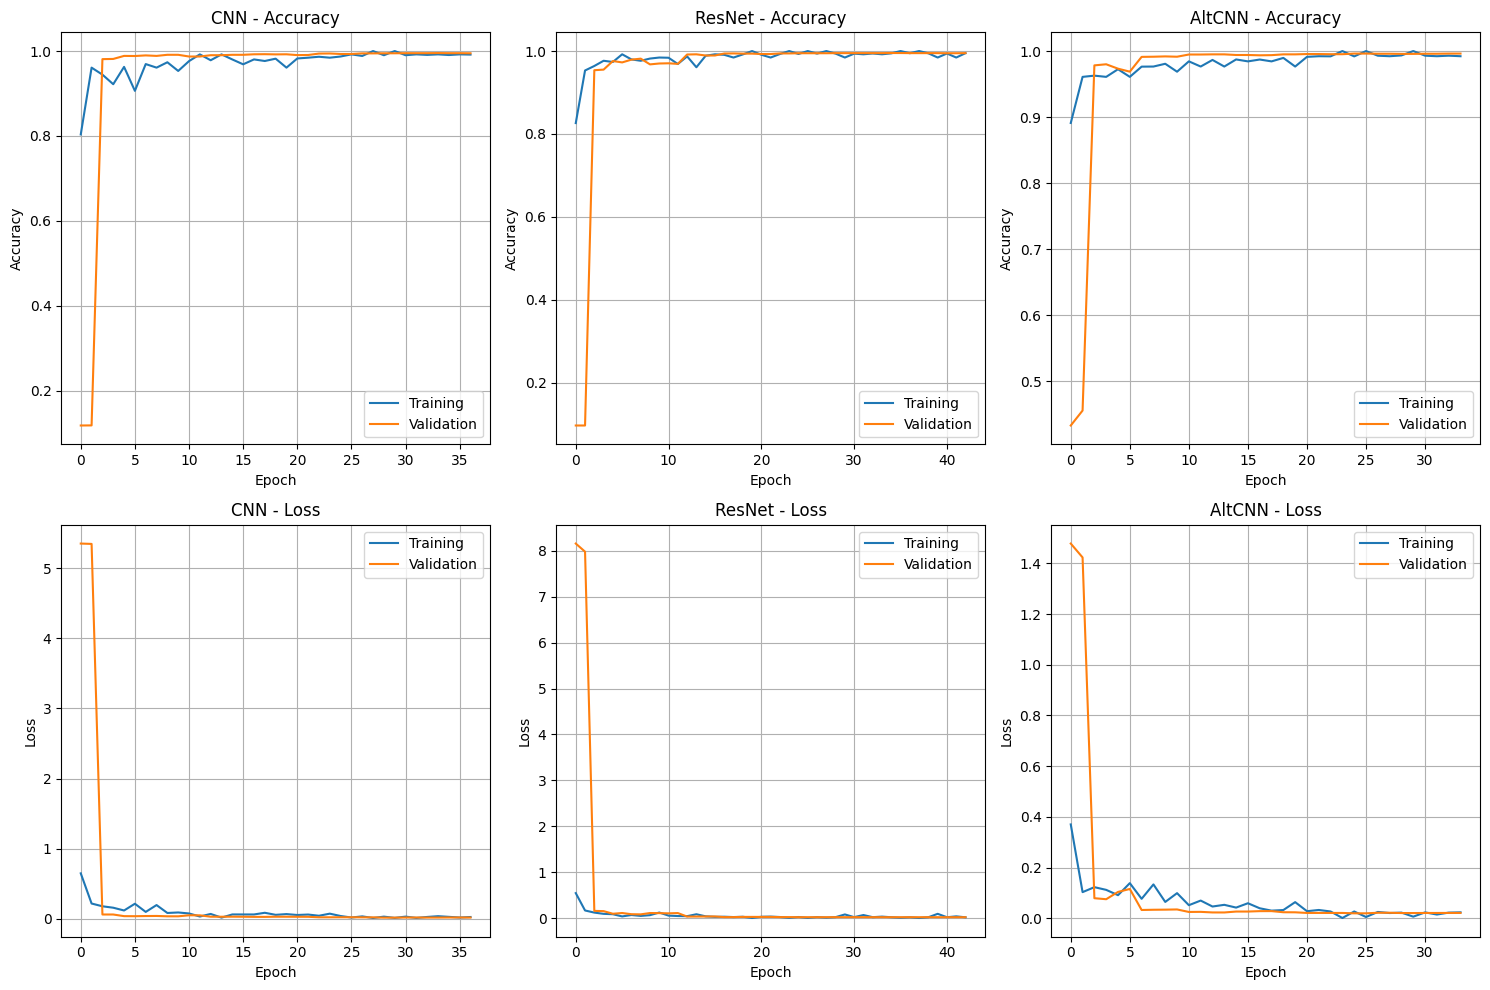

In [11]:
def main():
    system = DigitRecognitionSystem()
    
    try:
        system.load_and_preprocess_data('train.csv', 'test.csv')
        system.train_system(epochs=50, use_augmentation=True)
        system.evaluate_system()
        # Make predictions
        predictions = system.predict(use_tta=True)
        print(f"Made predictions for {len(predictions)} test samples")
        # Plot training history
        system.save_submission(predictions, 'submission.csv')
        system.plot_training_history()
        
    except FileNotFoundError:
        print("Training data files not found. Please provide train.csv and test.csv")
    except Exception as e:
        print(f"Error: {e}")


if __name__ == "__main__":
    main()

$$\textbf{What Makes Each Approach Different}$$

$\textbf{CNN vs ResNet vs Alternative CNN}$

| Aspect | Standard CNN | ResNet-Inspired | Alternative CNN |
|--------|-------------|-----------------|-----------------|
| **Key Innovation** | Progressive filtering | Skip connections | Design exploration |
| **Depth Strategy** | Moderate depth | Deeper with shortcuts | Different kernel approach |
| **Feature Extraction** | Hierarchical | Identity + Hierarchical | Large kernel + Hierarchical |
| **Regularization** | Dropout heavy | Batch norm heavy | Global pooling |
| **Parameter Efficiency** | Moderate | High (global pooling) | Lower (large dense layer) |

$\textbf{Single Model vs Ensemble}$

| Approach | Advantages | Disadvantages |
|----------|------------|---------------|
| **Single Model** | Fast, simple, interpretable | Limited by single architecture bias |
| **Ensemble** | Higher accuracy, robust, reduces overfitting | Slower inference, more complex |

$\textbf{With vs Without Augmentation}$

| Strategy | Benefits | Trade-offs |
|----------|----------|------------|
| **No Augmentation** | Faster training, less memory | May overfit, less robust |
| **With Augmentation** | Better generalization, more robust | Longer training, more complex |

$\textbf{Advanced Features}$

$\texttt{Test-Time Augmentation (TTA)}$

**Concept**: Apply augmentations during inference, not just training.

**Process**:
1. Make prediction on original image
2. Make predictions on rotated versions
3. Average all predictions
4. Return final class

**Benefit**: Often provides 1-2% accuracy improvement with minimal code changes.

$\texttt{Extensibility Features}$

The object-oriented design makes it easy to:

1. **Add new models**: Just inherit from `BaseModel`
2. **Change data processing**: Modify `DigitDataProcessor` or create new processor
3. **Experiment with ensembles**: Different voting strategies, model selection
4. **Add new augmentations**: Extend `DataAugmentor` class

$\textbf{Key Takeaways}$

$\texttt{Why This Approach is Powerful}$

1. **Modularity**: Each component has single responsibility
2. **Reusability**: Classes can be used in different contexts
3. **Maintainability**: Easy to debug and modify individual parts
4. **Scalability**: Can handle different datasets with minimal changes
5. **Performance**: Ensemble approach typically outperforms single models

$\texttt{Real-World Applications}$

This architecture pattern is valuable for:
- **Production ML systems** requiring reliability
- **Research environments** needing rapid experimentation
- **Educational purposes** demonstrating OOP in ML
- **Competition settings** where ensemble methods excel

The combination of solid software engineering principles with advanced machine learning techniques creates a robust, flexible, and high-performing digit recognition system.